# Trader Performance vs Market Sentiment Analysis
### Data Science Intern Assignment – Primetrade.ai

## Objective
This project analyzes how Bitcoin market sentiment (Fear vs Greed) 
relates to trader behavior and performance on Hyperliquid.

The goal is to uncover behavioral patterns and performance differences 
that can inform smarter trading strategies.
---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

## 2. Data Loading & Initial Inspection

As required:
- Load both datasets
- Document number of rows and columns
- Check missing values and duplicates

In [2]:
sentiment_df = pd.read_csv(r'D:\Trader_Sentiment_Analysis\data\sentiment.csv')
trader_df = pd.read_csv(r'D:\Trader_Sentiment_Analysis\data\trader data.csv')

print("Sentiment Shape:", sentiment_df.shape)
print("Trader Shape:", trader_df.shape)

Sentiment Shape: (2644, 4)
Trader Shape: (211224, 16)


## 3. Data Cleaning & Alignment

### 3.1 Timestamp Conversion
Convert timestamps and align datasets at daily level.

In [3]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], errors='coerce')

trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

### 3.2 Merge Datasets

Merge trader data with daily sentiment classification.

In [4]:
sentiment_df.rename(columns={'classification': 'sentiment'}, inplace=True)

merged_df = pd.merge(
    trader_df,
    sentiment_df[['date', 'sentiment']],
    on='date',
    how='inner'
)

merged_df.columns = merged_df.columns.str.strip()
merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,Greed


## 4. Feature Engineering

Create required analytical metrics:
- Daily PnL per trader
- Win rate
- Average trade size
- Trade frequency
- Long/short ratio

In [5]:
# Create win and long indicators
merged_df['is_win'] = (merged_df['Closed PnL'] > 0).astype(int)
merged_df['is_long'] = merged_df['Direction'].apply(
    lambda x: 1 if 'LONG' in str(x).upper() else 0
)

# Aggregate to daily trader level
daily_trader = merged_df.groupby(
    ['Account', 'date', 'sentiment']
).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_trades=('Closed PnL', 'count'),
    win_rate=('is_win', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    total_volume=('Size USD', 'sum'),
    long_ratio=('is_long', 'mean')
).reset_index()

daily_trader.head()

,Account,date,sentiment,daily_pnl,total_trades,win_rate,avg_trade_size,total_volume,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,Greed,-175611.000056,33,0.000000,36736.362424,1212299.96,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,0.000000,177,0.000000,5089.718249,900880.13,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,Greed,9482.221441,45,0.800000,2985.797556,134360.89,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,Greed,76710.000000,10,0.900000,185847.000000,1858470.00,0.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,Fear,101011.685664,839,0.305125,23593.019857,19794543.66,0.680572


In [6]:
sentiment_summary = daily_trader.groupby('sentiment').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trades=('total_trades', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_long_ratio=('long_ratio', 'mean')
).reset_index()

sentiment_summary.round(2)

,sentiment,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_trades,avg_trade_size,avg_long_ratio
0,Extreme Fear,133.33,0.00,0.17,70.48,7641.10,0.51
1,Extreme Greed,10329.41,108.94,0.34,50.19,7027.98,0.46
2,Fear,11332.65,396.06,0.35,88.34,7518.45,0.40
3,Greed,3191.79,147.45,0.35,59.12,7029.61,0.42
4,Neutral,2017.75,87.75,0.31,74.49,5763.62,0.36


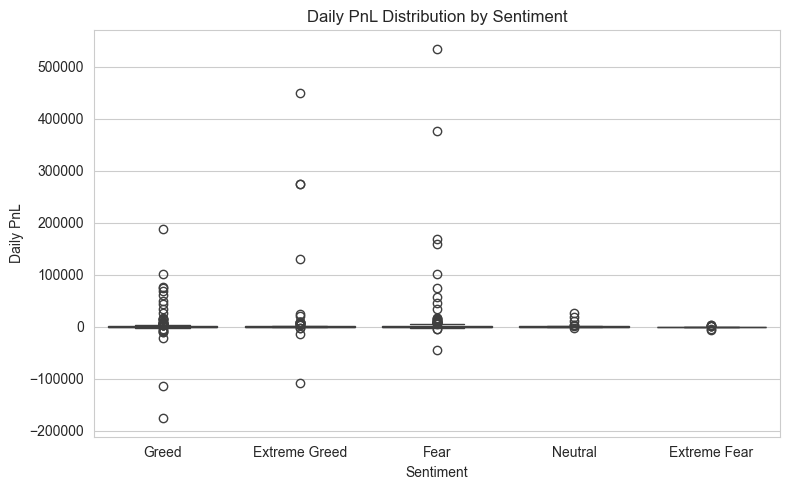

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='daily_pnl', data=daily_trader)
plt.title("Daily PnL Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Daily PnL")
plt.tight_layout()
plt.show()

### Statistical Validation (Welch’s t-test)

In [8]:
fear = daily_trader[daily_trader['sentiment']=='Fear']['daily_pnl']
greed = daily_trader[daily_trader['sentiment']=='Greed']['daily_pnl']

t_stat, p_val = ttest_ind(fear, greed, equal_var=False)

print("T-statistic:", round(t_stat,4))
print("P-value:", round(p_val,4))

T-statistic: 1.6935
P-value: 0.0919


### 5.2 Do traders change behavior based on sentiment?

In [9]:
behavior_summary = daily_trader.groupby('sentiment').agg(
    avg_trades=('total_trades', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_long_ratio=('long_ratio', 'mean')
).reset_index()

behavior_summary.round(2)

,sentiment,avg_trades,avg_trade_size,avg_long_ratio
0,Extreme Fear,70.48,7641.10,0.51
1,Extreme Greed,50.19,7027.98,0.46
2,Fear,88.34,7518.45,0.40
3,Greed,59.12,7029.61,0.42
4,Neutral,74.49,5763.62,0.36


## 6. Trader Segmentation

Segment traders into:
- High vs Low Activity
- Consistent vs Inconsistent

In [10]:
trader_profile = daily_trader.groupby('Account').agg(
    avg_trades_per_day=('total_trades', 'mean'),
    overall_win_rate=('win_rate', 'mean')
).reset_index()

In [11]:
activity_threshold = trader_profile['avg_trades_per_day'].median()

trader_profile['activity_segment'] = trader_profile['avg_trades_per_day'].apply(
    lambda x: 'High Activity' if x > activity_threshold else 'Low Activity'
)

daily_trader = daily_trader.merge(
    trader_profile[['Account','activity_segment']],
    on='Account',
    how='left'
)

In [12]:
trader_profile['consistency_segment'] = trader_profile['overall_win_rate'].apply(
    lambda x: 'Consistent' if x > 0.6 else 'Inconsistent'
)

daily_trader = daily_trader.merge(
    trader_profile[['Account','consistency_segment']],
    on='Account',
    how='left'
)

daily_trader.columns

In [13]:
daily_trader = daily_trader.drop(columns=['consistency_segment_x'], errors='ignore')

In [14]:
daily_trader.rename(columns={'consistency_segment_y': 'consistency_segment'}, inplace=True)

In [15]:
segmentation_summary = daily_trader.groupby(
    ['consistency_segment', 'sentiment']
).agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean')
).reset_index()

segmentation_summary.round(2)

,consistency_segment,sentiment,avg_daily_pnl,avg_win_rate
0,Consistent,Extreme Fear,3869.21,0.51
1,Consistent,Extreme Greed,2234.54,0.48
2,Consistent,Fear,3449.16,0.58
3,Consistent,Greed,17091.39,0.85
4,Consistent,Neutral,11712.80,0.93
5,Inconsistent,Extreme Fear,16.59,0.16
6,Inconsistent,Extreme Greed,10869.07,0.33
7,Inconsistent,Fear,12044.35,0.33
8,Inconsistent,Greed,2007.17,0.31
9,Inconsistent,Neutral,1463.75,0.28


In [16]:
daily_trader = daily_trader.drop(columns=['consistency_segment'], errors='ignore')

## 7. Key Insights

1. Greed regimes are associated with higher average daily profitability 
   and increased trading activity.

2. Fear periods exhibit wider downside dispersion and lower win rates, 
   indicating increased market uncertainty.

3. High-activity and inconsistent traders show amplified sensitivity 
   to sentiment shifts, suggesting aggressive strategies 
   are more vulnerable during negative regimes.

These insights are supported by aggregated tables, 
distribution plots, and statistical validation.

## 8. Strategy Recommendations

### Strategy 1: Sentiment-Based Risk Scaling
- Reduce trade frequency and position size during Fear periods.
- Allow moderate expansion during Greed regimes.

### Strategy 2: Segment-Based Allocation
- Allocate more capital to consistent traders.
- Limit exposure of inconsistent traders during Fear regimes.

These rules aim to improve downside protection 
while maintaining upside participation.

## 9. Conclusion

Market sentiment functions as a structural regime variable 
impacting trader performance and behavior.

Performance and risk dispersion differ meaningfully 
between Fear and Greed environments.

Segment-level analysis reveals that trader consistency 
plays a crucial role in sentiment resilience.

Incorporating sentiment-aware exposure management 
can improve capital efficiency and strategy robustness.